In [1]:
import os
os.chdir('/home/lewis/PhD/compounds-research')
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from importlib import reload
import datetime as dt
import seaborn as sns

from compounds_research.compound.utils import make_rates_df, make_original_df
from simulator.engine import dai_rate_model
from simulator.engine.dai_rate_params import PARAM_REGIMES, PARAM_REGIME_NUMS
%matplotlib inline

In [24]:
# regime_number = '0' #Started out below the kink, performance perhaps as desired. (0, 30000000, 100000)
# regime_number = '1' # Not a good mapping to predicted surface --> unsure why. (0, 30000000, 100000)
# regime_number = '2' # Not a good mapping to predicted surface --> unsure why. (0, 30000000, 100000)
# regime_number = '3' # Not a good mapping to predicted surface --> unsure why. (0, 50000000, 100000)
# regime_number = '4' # OK, below kink, performance perhaps as desired
# regime_number = '5' # Tightly clustered at kink
# regime_number = '6' # Tightly clustered at kink and above *plot np.arange(10000000, 40000000, 100000), (300,300), -100
# regime_number = '7' # Performance improved - base rate dropped, worse performance *plot, np.arange(10000000, 30000000, 100000), (200,200), -100
regime_number = '8' # Completely broken again, np.arange(15000000, 30000000, 100000), (150,150), -150. *plot
# regime_number = '9' # Tightly clustered just above kink
# regime_number ='10' #Tightly clustered at kink


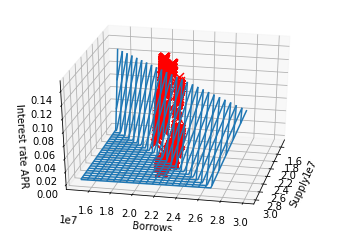

In [25]:
#BORROW RATES

fig = plt.figure()
ax = fig.gca(projection='3d')

#Model
reserves = 100000 # Arbitrary
supply = np.arange(15000000, 30000000, 100000)
borrows = np.arange(15000000, 30000000, 100000)
S, B = np.meshgrid(supply, borrows)

br_dict = {}
r_upscaled = reserves * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for s in supply:
        if s<b:
            continue
        s_upscaled = int(s) * int(1e18)
        cash_upscaled = s_upscaled - b_upscaled + r_upscaled
        br = dai_rate_model.get_borrow_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS[regime_number]])
        br_downscaled_APR = (br) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        br_dict[(s_upscaled,b_upscaled)] = br_downscaled_APR
        
Z_br = np.empty((150,150))
Z_br[:] = np.NaN

for key in br_dict:
    i = int(key[0] / int(1e23))-150
    j = int(key[1] / int(1e23))-150
    Z_br[j][i] = br_dict[key]

ax.plot_wireframe(X=S, Y=B, Z=Z_br, rcount = 25, ccount= 25, antialiased=True)

#Actual
df_cdai = make_original_df(token='cdai', resampling_frequency='D')
df_cdai = df_cdai[df_cdai['regime'] == float(regime_number)]

#Descriptive stats relative to the kink rate
df_cdai['kink_rate'] = (df_cdai['kink'] * df_cdai['multiplier_per_block'] / 1e18 + df_cdai['base_rate_per_block']) / 1e18 * dai_rate_model.BLOCKS_PER_YEAR

S_o = df_cdai['total_supply_history']
B_o = df_cdai['total_borrows_history']
Z_o = df_cdai['borrow_rates']
ax.scatter(S_o, B_o, Z_o, zdir='z', s=80, c='r', marker='x', depthshade=False)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=30, azim=12)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-observed-borrow' + str(regime_number)+ '.pdf', bbox_inches='tight', dpi = 300)
plt.show()

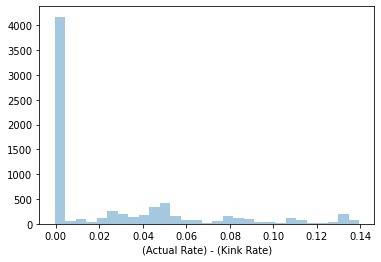

In [26]:
#Summary above the kink
df_cdai[df_cdai['borrow_rates'] > df_cdai['kink_rate']].describe()
#Summary below the kink
df_cdai[df_cdai['borrow_rates'] < df_cdai['kink_rate']].describe()
#Want to see distribution around the kink
df_cdai['(Actual Rate) - (Kink Rate)'] = df_cdai['borrow_rates'] - df_cdai['kink_rate']

sns_plot = sns.distplot(df_cdai['(Actual Rate) - (Kink Rate)'], kde=False)
fig = sns_plot.get_figure()
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-borrow-kink-deltas' + str(regime_number)+ '.pdf', bbox_inches='tight', dpi = 300)


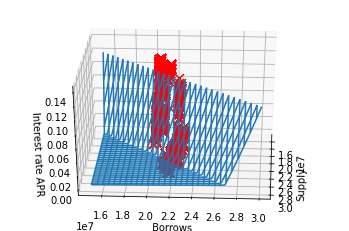

In [27]:
#SUPPLY RATES

fig = plt.figure()
ax = fig.gca(projection='3d')

#Model
sr_dict = {}
r_upscaled = reserves * int(1e18)
for b in borrows:
    b_upscaled = int(b) * int(1e18)
    for s in supply:
        if s<b:
            continue
        s_upscaled = int(s) * int(1e18)
        cash_upscaled = s_upscaled - b_upscaled + r_upscaled
        sr = dai_rate_model.get_supply_rate(cash=cash_upscaled, borrows=b_upscaled, reserves=r_upscaled, regime_params=PARAM_REGIMES[PARAM_REGIME_NUMS[regime_number]])
        sr_downscaled_APR = (sr) / int(1e18)* dai_rate_model.BLOCKS_PER_YEAR
        # util = dai_rate_model.utilization_rate(cash = cash_upscaled, borrows=b_upscaled, reserves=r_upscaled) / int(1e18)
        sr_dict[(s_upscaled,b_upscaled)] = sr_downscaled_APR
        
Z_sr = np.empty((150,150))
Z_sr[:] = np.NaN

for key in sr_dict:
    i = int(key[0] / int(1e23))-150
    j = int(key[1] / int(1e23))-150
    Z_sr[j][i] = sr_dict[key]

ax.plot_wireframe(X=S, Y=B, Z=Z_sr, rcount = 30, ccount= 30, antialiased=True)

#Actual

one_minus_reserve_factor = 1e18 - PARAM_REGIMES[PARAM_REGIME_NUMS[regime_number]]['reserve_factor']
borrow_rate = df_cdai['kink_rate']
rate_to_pool = borrow_rate * one_minus_reserve_factor / 1e18
savings_rate  = df_cdai['utilization_ratio'] * 1e18 * rate_to_pool / 1e18
df_cdai['kink_sr_rate'] =  savings_rate

S_o = df_cdai['total_supply_history']
B_o = df_cdai['total_borrows_history']
Z_o = df_cdai['supply_rates']
ax.scatter(S_o, B_o, Z_o, zdir='z', s=80, c='r', marker='x', depthshade=False)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=30, azim=3)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-observed-supply' + str(regime_number)+ '.pdf', bbox_inches='tight', dpi = 300)
plt.show()

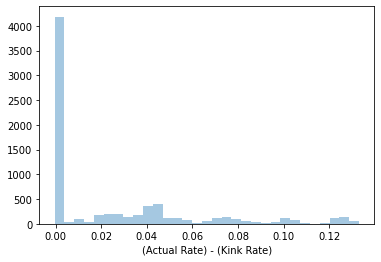

In [30]:
#Summary around the kink
df_cdai[df_cdai['supply_rates'] > df_cdai['kink_sr_rate']].describe()
df_cdai[df_cdai['supply_rates'] < df_cdai['kink_sr_rate']].describe()
df_cdai['(Actual Rate) - (Kink Rate)'] = df_cdai['supply_rates'] - df_cdai['kink_sr_rate']

sns_plot = sns.distplot(df_cdai['(Actual Rate) - (Kink Rate)'], kde=False)
fig = sns_plot.get_figure()
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-supply-kink-deltas' + str(regime_number)+ '.pdf', bbox_inches='tight', dpi = 300)

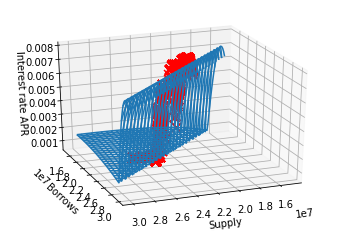

In [31]:
fig = plt.figure()
ax = fig.gca(projection='3d')

#Model
Z_delta = Z_br - Z_sr
ax.plot_wireframe(X=S, Y=B, Z=Z_delta, rcount = 30, ccount= 30, antialiased=True)

#Observed
S_o = df_cdai['total_supply_history']
B_o = df_cdai['total_borrows_history']
Z_o = df_cdai['borrow_rates'] - df_cdai['supply_rates']

ax.scatter(S_o, B_o, Z_o, zdir='z', s=80, c='r', marker='x', depthshade=False)

ax.set_xlabel('Supply')
ax.set_ylabel('Borrows')
ax.set_zlabel('Interest rate APR')
ax.view_init(elev=26, azim=69)
fig.savefig('../overleaf/5e6bad2e6490390001d3c466/images/compound-observed-delta' + str(regime_number)+ '.pdf', bbox_inches='tight', dpi = 300)
plt.show()